# Seq2Vec Sentiment Modeling in Tensorflow

## 1.0 - Import Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd
from sklearn.metrics import mean_absolute_error
from keras import backend as K
from keras.layers import Dropout
import os
import numpy as np
import seaborn as sns
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import *
# from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
CUR_DIR = os.path.abspath(os.curdir)
ROOT_DIR = os.path.dirname(CUR_DIR)
IMAGES_DIR = os.path.join(ROOT_DIR, "images")
DATA_DIR = os.path.join(ROOT_DIR, "data")
MODELS_DIR = os.path.join(ROOT_DIR, "models")
EVAL_DIR = os.path.join(ROOT_DIR, "evaluation")
MODEL_PERF_DIR = os.path.join(EVAL_DIR, "model_performance")
GRAPHS_DIR = os.path.join(EVAL_DIR, "graphs")
writepath = os.path.join(MODEL_PERF_DIR, "performance.csv")

## 1.1 Import Data 

In [3]:
validation_df = pd.read_csv(os.path.join(DATA_DIR,'raw','validation.csv'))
training_df = pd.read_csv(os.path.join(DATA_DIR,'raw','training_balanced.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR,'raw','test.csv'))

X_train = training_df['review']
y_train = training_df['star']
      
X_val = validation_df['review']
y_val = validation_df['star']

X_test = test_df['review']
y_test = test_df['star']

# Convert to tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size=1024).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).shuffle(buffer_size=1024).batch(128) 
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(buffer_size=1024).batch(128)

2022-03-16 05:59:54.498556: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 05:59:54.498681: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 05:59:54.498733: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (42b10f96906e): /proc/driver/nvidia/version does not exist
2022-03-16 05:59:54.499726: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.0 Create embedding layer & Build simple model

In [4]:
handle = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1'

emb_layer = hub.KerasLayer(handle = handle, output_shape=(20,1),
               input_shape=(None,),dtype=tf.string,trainable=True, name='embed')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

2022-03-16 05:59:55.048051: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
embed = hub.load(handle)
embeddings = embed(["man","woman"])
embeddings

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[ 3.9687425e-01, -6.3695002e-01, -6.7363518e-01, -1.3100165e-01,
         5.2906036e-01,  2.3391739e-01, -1.7667708e-01,  1.0469885e+00,
         1.5244880e+00,  8.3604610e-01, -7.9439002e-01,  1.0453002e-01,
        -2.2940248e-02, -1.4738902e-01, -8.3987337e-01,  1.0697368e+00,
        -4.5744944e-01, -4.4647139e-01, -1.3669002e+00,  1.6243970e-01],
       [ 4.5780963e-01, -6.5106559e-01, -4.7487444e-01, -1.3545550e-01,
         7.5560737e-01,  1.3068053e-01, -2.7652311e-01,  1.2009813e+00,
         1.6298714e+00,  1.1437336e+00, -6.3142008e-01,  6.7427382e-04,
        -3.1341049e-01, -2.5012997e-01, -8.7322730e-01,  7.1451533e-01,
        -4.2308569e-01, -7.8139108e-01, -1.1334857e+00,  1.6536513e-01]],
      dtype=float32)>

## Baseline

In [6]:
epochs = 100

base_model = keras.Sequential([
        layers.Input(shape=(), name="Input", dtype=tf.string),
        emb_layer,
        layers.Dense(8,activation='relu', dtype=tf.float32),
        layers.Dense(1,activation=relu_advanced)],name='2.2-Base-No-Reg-Balance')

base_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=keras.optimizers.Adam(lr=0.0003,decay=1e-6),
                   metrics=['mae'])


base_history = base_model.fit(train_ds,
                    epochs = epochs,
                    validation_data=val_ds,
                    callbacks=[callback],
                    verbose=1)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
4083/4083 [==============================] - 39s 9ms/step - loss: 1.9156 - mae: 0.9187 - val_loss: 3.5648 - val_mae: 1.7353
Epoch 2/100
4083/4083 [==============================] - 46s 11ms/step - loss: 0.3391 - mae: 0.3851 - val_loss: 3.3262 - val_mae: 1.7023
Epoch 3/100
4083/4083 [==============================] - 59s 15ms/step - loss: 0.2268 - mae: 0.2906 - val_loss: 3.2057 - val_mae: 1.6787
Epoch 4/100
4083/4083 [==============================] - 53s 13ms/step - loss: 0.1805 - mae: 0.2429 - val_loss: 3.1465 - val_mae: 1.6643
Epoch 5/100
4083/4083 [==============================] - 49s 12ms/step - loss: 0.1583 - mae: 0.2167 - val_loss: 3.1300 - val_mae: 1.6600
Epoch 6/100
4083/4083 [==============================] - 60s 15ms/step - loss: 0.1436 - mae: 0.2000 - val_loss: 3.1292 - val_mae: 1.6599
Epoch 7/100
4083/4083 [==============================] - 61s 15ms/step - loss: 0.1367 - mae: 0.1929 - val_loss: 3.1366 - val_mae: 1.6620
Epoch 8/100
4083/4083 [===================

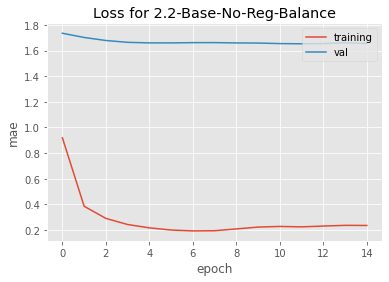

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.2-Base-No-Reg-Balance.png


In [7]:
plot_loss(base_history,base_model)

The prediction values range between [2.] and [5.]
Mean Absolute Error: 1.6655095204207384


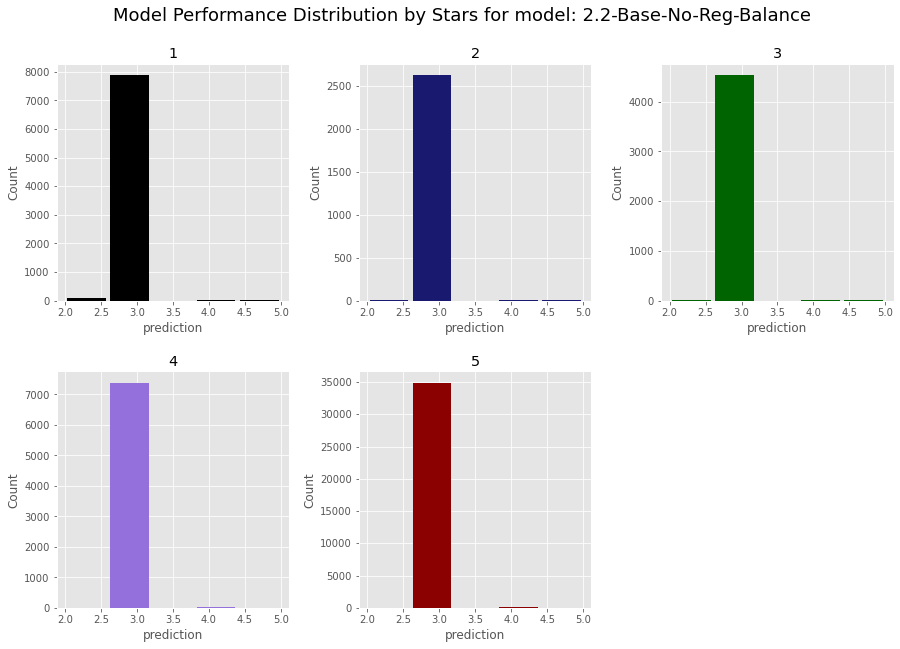

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


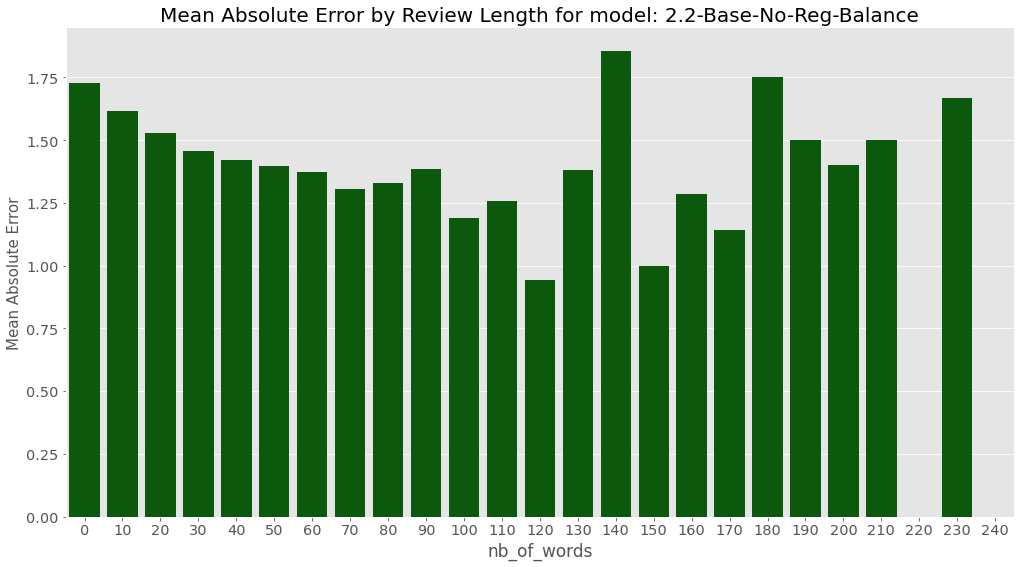

Performance appended successfully.


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      7964
           2       0.04      0.00      0.00      2640
           3       0.08      0.99      0.15      4548
           4       0.15      0.00      0.01      7414
           5       0.30      0.00      0.00     35047

    accuracy                           0.08     57613
   macro avg       0.11      0.20      0.03     57613
weighted avg       0.21      0.08      0.01     57613

"I like the top but it took long to deliver" receives a score of [3.2050698]
"This app is trash" receives a score of [2.7017589]
"The app is extremely slow, but I still like it" receives a score of [2.985207]
"I Do not Love this App" receives a score of [3.0357141]
"Too many glitches" receives a score of [2.8945541]
"Worthless app" receives a score of [2.9360929]
"Do not download this app" receives a score of [2.9311]
"Horrible" receives a score of [3.0241156]
"Could be better but is serviceable" receives 

In [8]:
performance_evaluation(X_test, y_test, base_model)

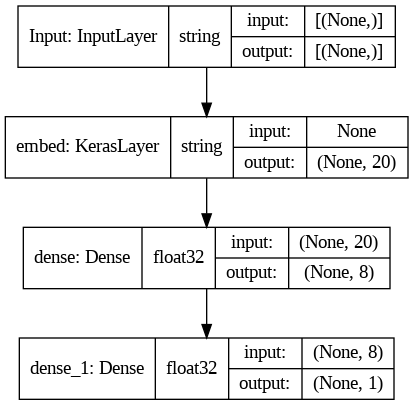

In [9]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{base_model.name}.png')
tf.keras.utils.plot_model(base_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [10]:
base_model.save(os.path.join(MODELS_DIR,base_model.name))

2022-03-16 06:17:48.198143: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.2-Base-No-Reg-Balance/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.2-Base-No-Reg-Balance/assets


## RNN

In [11]:
embed
embed(X_train).shape

2022-03-16 06:18:01.897001: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 195441288 exceeds 10% of free system memory.


TensorShape([522620, 20])

In [12]:
rnn_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.SimpleRNN(8, activation='tanh',return_sequences=False),
    layers.Dense(1,activation=relu_advanced)
],name='2.2-RNN-No-Reg-Balance-Swivel')

rnn_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mae'])

num_epochs=100
rnn_history=rnn_model.fit(train_ds, 
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
4083/4083 [==============================] - 151s 36ms/step - loss: 0.5866 - mae: 0.3026 - val_loss: 3.1352 - val_mae: 1.6600
Epoch 2/100
4083/4083 [==============================] - 140s 34ms/step - loss: 0.0719 - mae: 0.0682 - val_loss: 3.1452 - val_mae: 1.6620
Epoch 3/100
4083/4083 [==============================] - 168s 41ms/step - loss: 0.0681 - mae: 0.0577 - val_loss: 3.1484 - val_mae: 1.6626
Epoch 4/100
4083/4083 [==============================] - 171s 42ms/step - loss: 0.0713 - mae: 0.0584 - val_loss: 3.1509 - val_mae: 1.6629


In [13]:
rnn_model.summary()

Model: "2.2-RNN-No-Reg-Balance-Swivel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (KerasLayer)           (None, 20)                389380    
_________________________________________________________________
reshape (Reshape)            (None, 20, 1)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 8)                 80        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 389,469
Trainable params: 389,469
Non-trainable params: 0
_________________________________________________________________


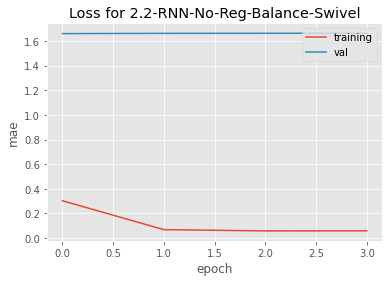

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.2-RNN-No-Reg-Balance-Swivel.png


In [14]:
plot_loss(rnn_history,rnn_model)

The prediction values range between [1.] and [3.]
Mean Absolute Error: 1.6678700987624322


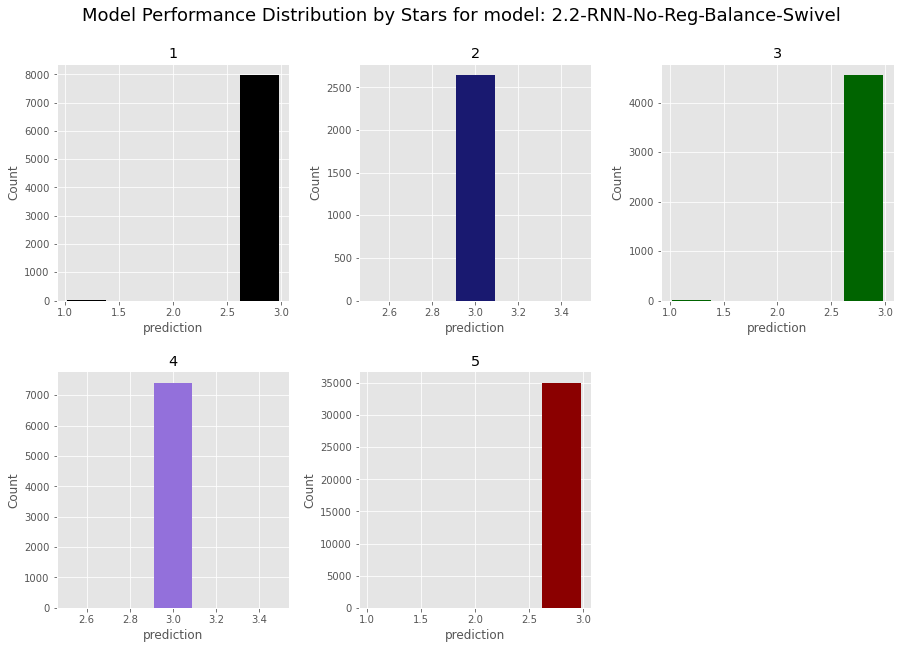

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


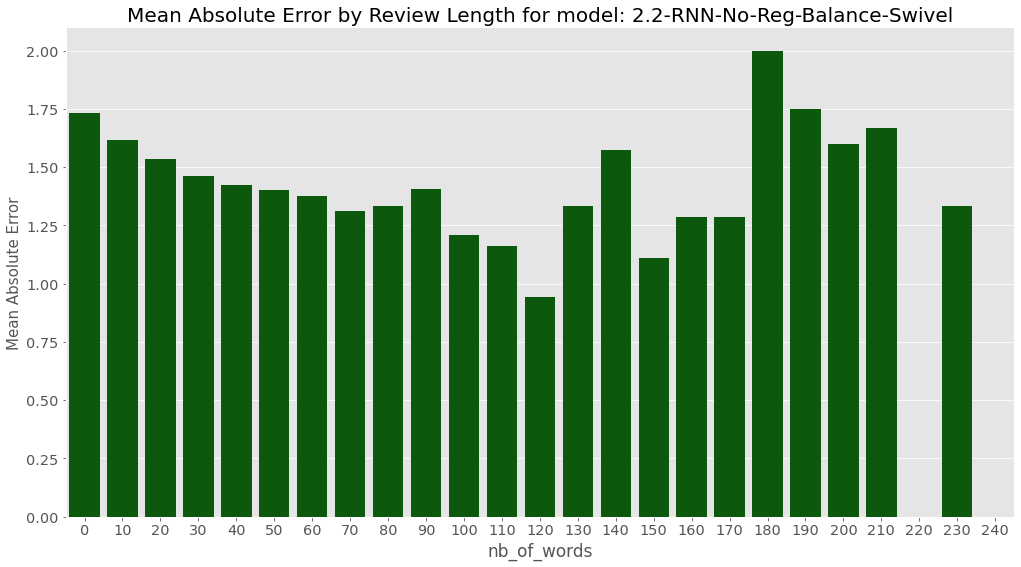

Performance appended successfully.


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.17      0.00      0.00      7964
           2       0.00      0.00      0.00      2640
           3       0.08      1.00      0.15      4548
           4       0.00      0.00      0.00      7414
           5       0.00      0.00      0.00     35047

    accuracy                           0.08     57613
   macro avg       0.05      0.20      0.03     57613
weighted avg       0.03      0.08      0.01     57613

"I like the top but it took long to deliver" receives a score of [2.993757]
"This app is trash" receives a score of [2.9987433]
"The app is extremely slow, but I still like it" receives a score of [3.0001724]
"I Do not Love this App" receives a score of [3.0016878]
"Too many glitches" receives a score of [3.0009367]
"Worthless app" receives a score of [2.9980798]
"Do not download this app" receives a score of [2.9997296]
"Horrible" receives a score of [2.9998205]
"Could be better but is serviceable" receiv

In [15]:
performance_evaluation(X_test, y_test, rnn_model)

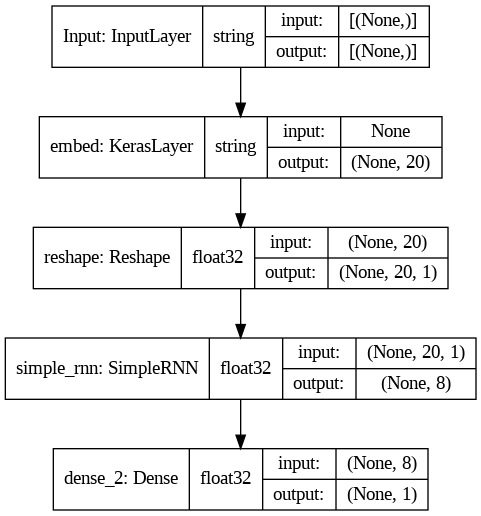

In [16]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{rnn_model.name}.png')
tf.keras.utils.plot_model(rnn_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [17]:
rnn_model.save(os.path.join(MODELS_DIR,rnn_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.2-RNN-No-Reg-Balance-Swivel/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.2-RNN-No-Reg-Balance-Swivel/assets


In [18]:
# max(y_pred)

In [19]:
gru_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.GRU(10, activation='tanh',return_sequences=False),
    layers.Dense(5,activation='tanh'),
    layers.Dense(1,activation=relu_advanced)
],name='2.2-GRU-No-Reg-Balance-Swivel')
gru_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mae'])

num_epochs=100
gru_history=gru_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
4083/4083 [==============================] - 173s 40ms/step - loss: 0.4774 - mae: 0.1921 - val_loss: 3.1419 - val_mae: 1.6612
Epoch 2/100
4083/4083 [==============================] - 153s 37ms/step - loss: 0.0460 - mae: 0.0457 - val_loss: 3.1443 - val_mae: 1.6619
Epoch 3/100
4083/4083 [==============================] - 152s 37ms/step - loss: 0.0504 - mae: 0.0476 - val_loss: 3.1450 - val_mae: 1.6619
Epoch 4/100
4083/4083 [==============================] - 148s 36ms/step - loss: 0.0567 - mae: 0.0523 - val_loss: 3.1381 - val_mae: 1.6604
Epoch 5/100
4083/4083 [==============================] - 135s 33ms/step - loss: 0.0609 - mae: 0.0552 - val_loss: 3.1425 - val_mae: 1.6614
Epoch 6/100
4083/4083 [==============================] - 142s 35ms/step - loss: 0.0749 - mae: 0.0651 - val_loss: 3.1479 - val_mae: 1.6625
Epoch 7/100
4083/4083 [==============================] - 134s 33ms/step - loss: 0.0740 - mae: 0.0632 - val_loss: 3.1432 - val_mae: 1.6612


In [20]:
gru_model.save(os.path.join(MODELS_DIR,gru_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.2-GRU-No-Reg-Balance-Swivel/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.2-GRU-No-Reg-Balance-Swivel/assets


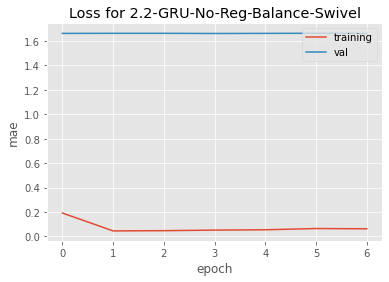

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.2-GRU-No-Reg-Balance-Swivel.png


In [21]:
plot_loss(gru_history,gru_model)

The prediction values range between [3.] and [3.]
Mean Absolute Error: 1.6676097408570982


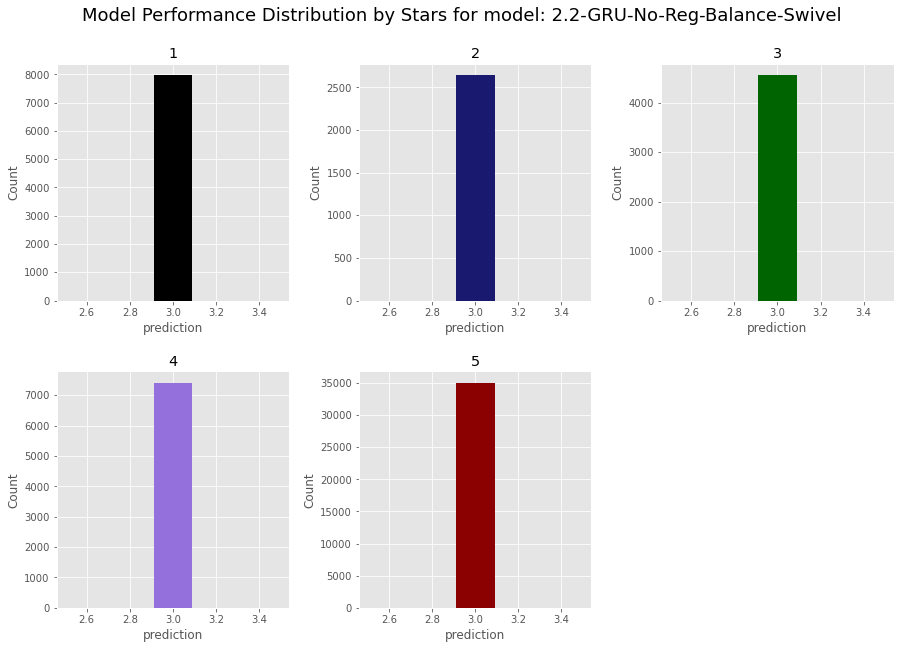

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


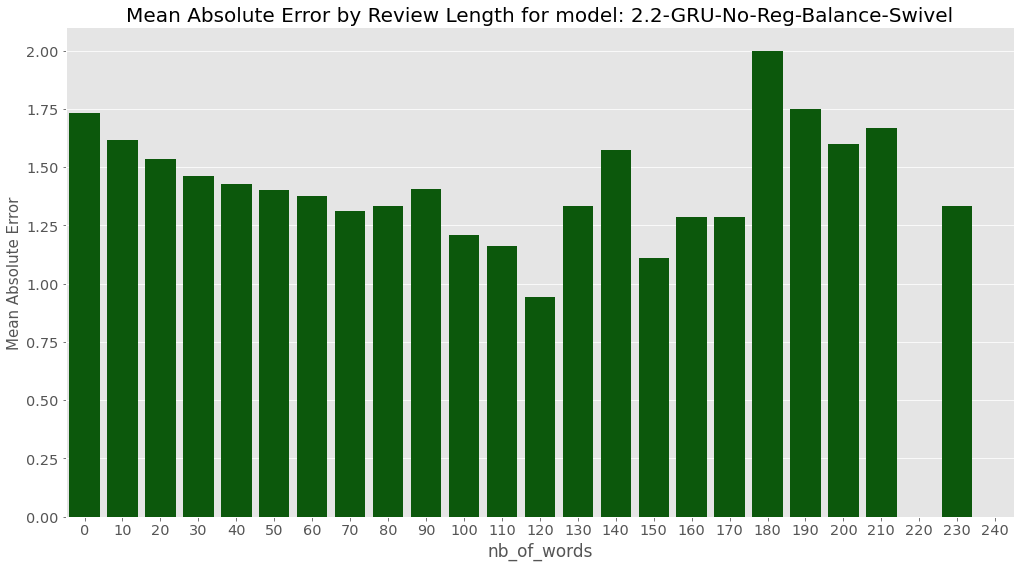

Performance appended successfully.
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      7964
           2       0.00      0.00      0.00      2640
           3       0.08      1.00      0.15      4548
           4       0.00      0.00      0.00      7414
           5       0.00      0.00      0.00     35047

    accuracy                           0.08     57613
   macro avg       0.02      0.20      0.03     57613
weighted avg       0.01      0.08      0.01     57613



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


"I like the top but it took long to deliver" receives a score of [2.9987497]
"This app is trash" receives a score of [3.0020232]
"The app is extremely slow, but I still like it" receives a score of [2.9982522]
"I Do not Love this App" receives a score of [3.0040011]
"Too many glitches" receives a score of [3.001822]
"Worthless app" receives a score of [3.0042534]
"Do not download this app" receives a score of [3.0018036]
"Horrible" receives a score of [3.002521]
"Could be better but is serviceable" receives a score of [3.0021167]
"The servers are always down" receives a score of [3.0011363]
None
Done


In [22]:
performance_evaluation(X_test, y_test, gru_model)

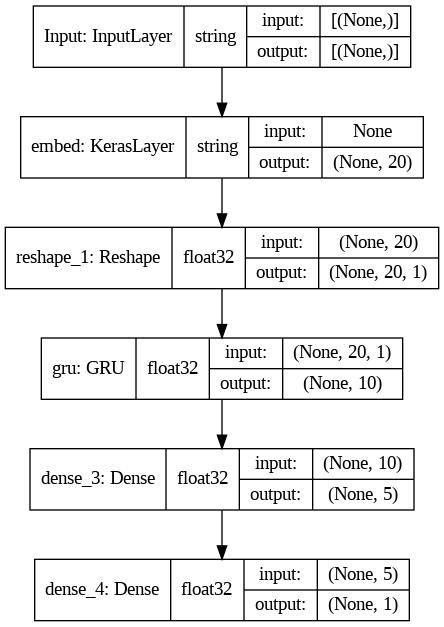

In [23]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{gru_model.name}.png')
tf.keras.utils.plot_model(gru_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

## LSTM

In [24]:
lstm_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.LSTM(10, activation='tanh',return_sequences=False),
    layers.Dense(5,activation='tanh'),
    layers.Dense(1,activation=relu_advanced)
],name='2.2-LSTM-No-Reg-Balance-Swivel')
lstm_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mse','mae'])

num_epochs=100
lstm_history=lstm_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
4083/4083 [==============================] - 182s 43ms/step - loss: 0.8980 - mse: 0.8980 - mae: 0.3927 - val_loss: 3.1476 - val_mse: 3.1476 - val_mae: 1.6625
Epoch 2/100
4083/4083 [==============================] - 150s 37ms/step - loss: 0.0866 - mse: 0.0866 - mae: 0.0736 - val_loss: 3.1453 - val_mse: 3.1453 - val_mae: 1.6618
Epoch 3/100
4083/4083 [==============================] - 144s 35ms/step - loss: 0.0885 - mse: 0.0885 - mae: 0.0716 - val_loss: 3.1393 - val_mse: 3.1393 - val_mae: 1.6604
Epoch 4/100
4083/4083 [==============================] - 99s 24ms/step - loss: 0.0892 - mse: 0.0892 - mae: 0.0735 - val_loss: 3.1382 - val_mse: 3.1382 - val_mae: 1.6602
Epoch 5/100
4083/4083 [==============================] - 95s 23ms/step - loss: 0.0885 - mse: 0.0885 - mae: 0.0741 - val_loss: 3.1433 - val_mse: 3.1433 - val_mae: 1.6614
Epoch 6/100
4083/4083 [==============================] - 100s 24ms/step - loss: 0.0889 - mse: 0.0889 - mae: 0.0740 - val_loss: 3.1384 - val_mse: 3.1384 

The prediction values range between [2.] and [3.]
Mean Absolute Error: 1.668321385798344


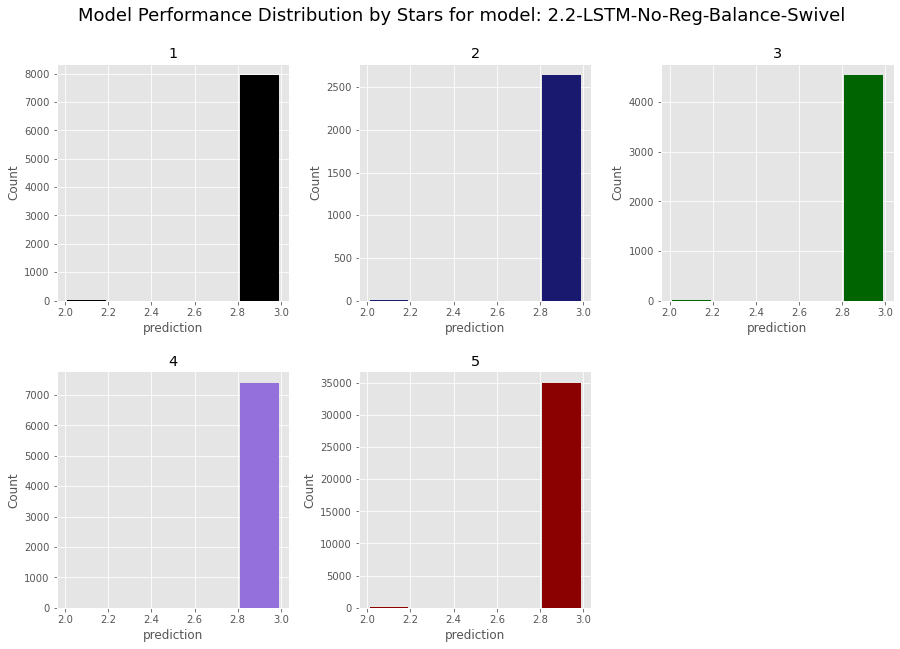

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


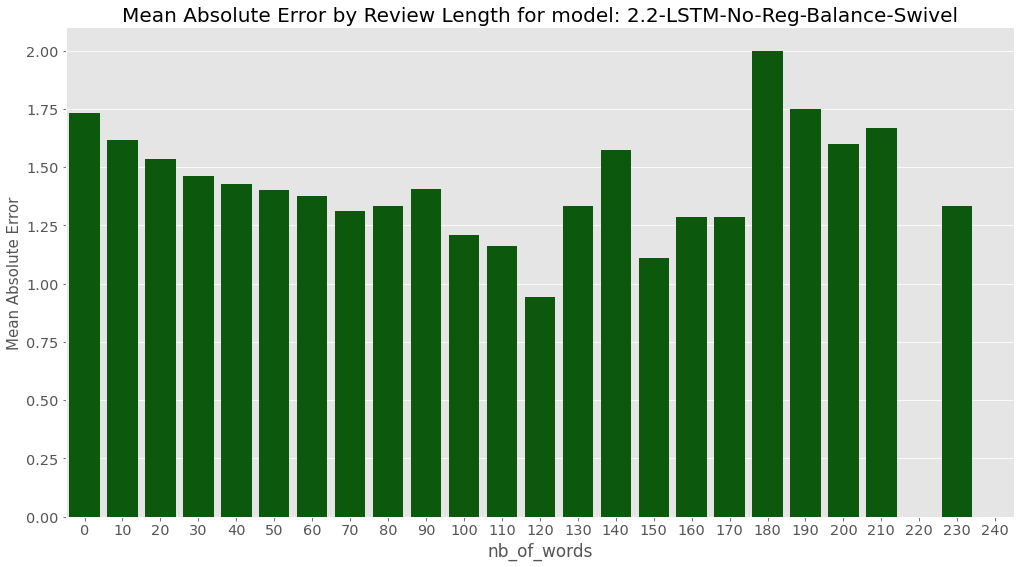

Performance appended successfully.
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      7964
           2       0.02      0.00      0.00      2640
           3       0.08      1.00      0.15      4548
           4       0.00      0.00      0.00      7414
           5       0.00      0.00      0.00     35047

    accuracy                           0.08     57613
   macro avg       0.02      0.20      0.03     57613
weighted avg       0.01      0.08      0.01     57613



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


"I like the top but it took long to deliver" receives a score of [3.0356183]
"This app is trash" receives a score of [2.9711657]
"The app is extremely slow, but I still like it" receives a score of [3.005758]
"I Do not Love this App" receives a score of [2.9835806]
"Too many glitches" receives a score of [2.9644756]
"Worthless app" receives a score of [3.0060625]
"Do not download this app" receives a score of [2.9608707]
"Horrible" receives a score of [2.9713857]
"Could be better but is serviceable" receives a score of [3.0208008]
"The servers are always down" receives a score of [2.9725618]
None
Done


In [25]:
performance_evaluation(X_test, y_test, lstm_model)

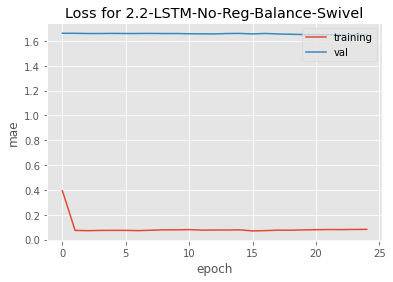

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.2-LSTM-No-Reg-Balance-Swivel.png


In [26]:
plot_loss(lstm_history,lstm_model)

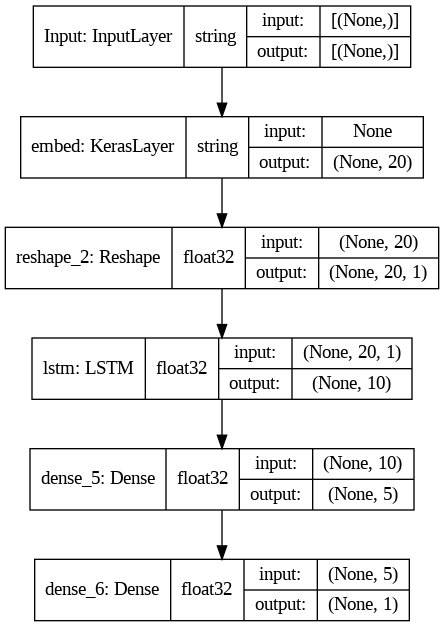

In [27]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{lstm_model.name}.png')
tf.keras.utils.plot_model(lstm_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [28]:
lstm_model.save(os.path.join(MODELS_DIR,lstm_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.2-LSTM-No-Reg-Balance-Swivel/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.2-LSTM-No-Reg-Balance-Swivel/assets
